In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import chart_studio.plotly as py
import chart_studio.tools as tls
import cufflinks as cf

## zipcode to geomatric map
import pgeocode

import os, glob

### 1. Querying the data from google big query for taxi demands 2015 

In [71]:
def big_query_monthly(month):
    """
    A function: Query for GCP, extract the counts of taxi demands per hour and monthly and to_csv
    """
       
    sql = """
    SELECT 
        DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
        pickup_latitude,
        pickup_longitude,
        dropoff_longitude
        count(*) as cnt
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
    WHERE EXTRACT(MONTH from pickup_datetime) = {0}
    GROUP BY pickup_hour
    ORDER BY pickup_hour
    """
    
    bq = pd.read_gbq(query=sql.format(month), dialect='standard', 
                     project_id='direct-plateau-291323', auth_local_webserver=True)
    
    return bq.to_csv('nyc-yellow-taxi-2015-{}.csv'.format(month))

In [34]:
## calling big_query_monthly function in loop for every month data 

for i in range(1,13):
    big_query_monthly(i)

In [56]:
## csv file merging preps

path = os.getcwd()

all_files = glob.glob(os.path.join(path, "nyc-yellow-taxi-2015-*.csv"))

all_df = []

for f in all_files:
    df = pd.read_csv(f, sep=',')
    all_df.append(df)
    
merged_df = pd.concat(all_df, ignore_index=True, sort=True)


In [57]:
all_files

['/Users/sangdonlee/GitHub/iod/materials/mini3/nyc-yellow-taxi-2015-8.csv',
 '/Users/sangdonlee/GitHub/iod/materials/mini3/nyc-yellow-taxi-2015-9.csv',
 '/Users/sangdonlee/GitHub/iod/materials/mini3/nyc-yellow-taxi-2015-7.csv',
 '/Users/sangdonlee/GitHub/iod/materials/mini3/nyc-yellow-taxi-2015-12.csv',
 '/Users/sangdonlee/GitHub/iod/materials/mini3/nyc-yellow-taxi-2015-6.csv',
 '/Users/sangdonlee/GitHub/iod/materials/mini3/nyc-yellow-taxi-2015-4.csv',
 '/Users/sangdonlee/GitHub/iod/materials/mini3/nyc-yellow-taxi-2015-11.csv',
 '/Users/sangdonlee/GitHub/iod/materials/mini3/nyc-yellow-taxi-2015-10.csv',
 '/Users/sangdonlee/GitHub/iod/materials/mini3/nyc-yellow-taxi-2015-5.csv',
 '/Users/sangdonlee/GitHub/iod/materials/mini3/nyc-yellow-taxi-2015-1.csv',
 '/Users/sangdonlee/GitHub/iod/materials/mini3/nyc-yellow-taxi-2015-2.csv',
 '/Users/sangdonlee/GitHub/iod/materials/mini3/nyc-yellow-taxi-2015-3.csv']

In [38]:
merged_df = pd.read_csv('nyc-yellow-taxi-2015-total.csv')

In [39]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   8760 non-null   int64 
 1   cnt          8760 non-null   int64 
 2   pickup_hour  8760 non-null   object
dtypes: int64(2), object(1)
memory usage: 205.4+ KB


In [40]:
merged_df['pickup_hour'] = pd.to_datetime(merged_df['pickup_hour'])

In [41]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   8760 non-null   int64         
 1   cnt          8760 non-null   int64         
 2   pickup_hour  8760 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 205.4 KB


In [42]:
## order by pickup_hour
merged_df = merged_df.sort_values(by='pickup_hour')

In [43]:
## drop unneccssary column
merged_df = merged_df.drop('Unnamed: 0', axis=1)

In [44]:
merged_df.tail()

,cnt,pickup_hour
8755,21086,2015-12-31 19:00:00
8756,22814,2015-12-31 20:00:00
8757,23857,2015-12-31 21:00:00
8758,21387,2015-12-31 22:00:00
8759,17330,2015-12-31 23:00:00


In [74]:
merged_df.to_csv('nyc-yellow-taxi-2015-total.csv')

### 2. Visualisation

In [45]:
merged_df = merged_df.set_index('pickup_hour')

In [48]:
merged_df.iplot(kind='scatter',xTitle='Date & Hour',yTitle='Demand',title='NYC Taxi Demand Year 2015')

In [49]:
merged_df['date'] = merged_df.index.date

In [50]:
merged_df.head()

,cnt,date
pickup_hour,,
2015-01-01 00:00:00,28312,2015-01-01
2015-01-01 01:00:00,31707,2015-01-01
2015-01-01 02:00:00,28068,2015-01-01
2015-01-01 03:00:00,24288,2015-01-01
2015-01-01 04:00:00,17081,2015-01-01


In [51]:
merged_df.groupby(['date'])[['cnt']].sum().iplot(kind='scatter',xTitle='Date',yTitle='Demand',title='NYC Taxi Demand Year 2015')

In [52]:
## adding weekday, number. 

merged_df['weekday'] = merged_df.index.weekday
merged_df['hour'] = merged_df.index.hour
merged_df['weeknum'] = merged_df.index.week

/Users/sangdonlee/opt/anaconda3/envs/bigquery/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



In [53]:
merged_df.head()

,cnt,date,weekday,hour,weeknum
pickup_hour,,,,,
2015-01-01 00:00:00,28312,2015-01-01,3,0,1
2015-01-01 01:00:00,31707,2015-01-01,3,1,1
2015-01-01 02:00:00,28068,2015-01-01,3,2,1
2015-01-01 03:00:00,24288,2015-01-01,3,3,1
2015-01-01 04:00:00,17081,2015-01-01,3,4,1


In [54]:
merged_df.tail()

,cnt,date,weekday,hour,weeknum
pickup_hour,,,,,
2015-12-31 19:00:00,21086,2015-12-31,3,19,53
2015-12-31 20:00:00,22814,2015-12-31,3,20,53
2015-12-31 21:00:00,23857,2015-12-31,3,21,53
2015-12-31 22:00:00,21387,2015-12-31,3,22,53
2015-12-31 23:00:00,17330,2015-12-31,3,23,53


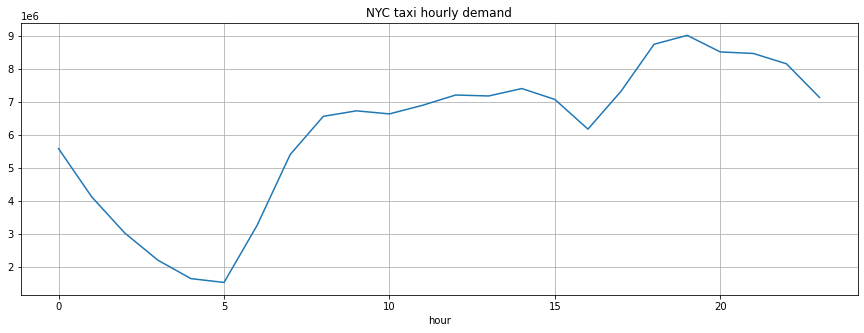

In [55]:
merged_df.groupby('hour')['cnt'].sum().plot(x='hour', y='cnt', figsize=(15,5), title='NYC taxi hourly demand', grid=True);

In [56]:
merged_df.groupby(['hour', 'weekday'])['cnt'].mean().unstack()

weekday,0,1,2,3,4,5,6
hour,,,,,,,
0,8718.923077,9016.692308,11516.019231,13467.339623,17125.942308,23356.423077,23986.500000
1,5252.673077,5316.115385,6777.942308,8390.905660,11296.884615,20118.500000,22040.596154
2,3443.634615,3329.903846,4216.403846,5448.867925,7410.038462,16552.903846,17769.692308
3,2429.307692,2188.961538,2821.269231,3691.339623,4980.730769,12339.038462,13936.730769
4,2597.653846,2231.211538,2650.634615,3237.075472,4019.903846,7953.442308,8947.615385
5,4157.057692,3965.711538,4116.730769,4335.377358,4543.365385,4079.403846,4194.500000
6,10197.461538,10718.057692,10988.807692,10903.377358,10491.980769,4966.346154,4286.884615
7,16613.038462,18442.326923,19180.673077,18863.433962,17727.980769,7216.903846,5631.519231
8,19599.346154,21712.326923,22527.038462,21928.113208,20833.192308,10886.711538,8374.788462


<AxesSubplot:xlabel='hour'>

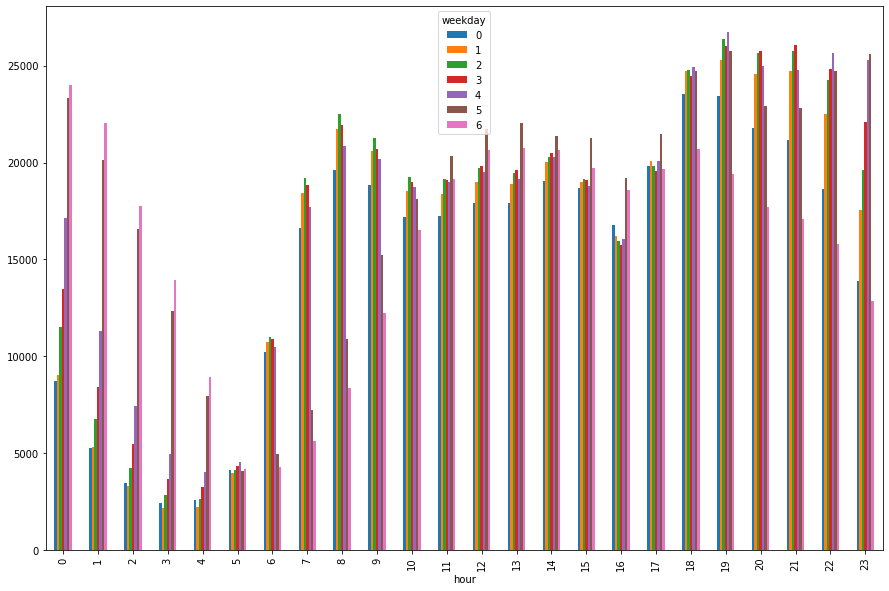

In [102]:
ax = merged_df.groupby(['hour', 'weekday'])['cnt'].mean().unstack().plot(kind='bar', figsize=(15,10))

In [60]:
## adding is_weekend column

merged_df['is_weekend'] = ((pd.DatetimeIndex(merged_df.index).dayofweek) // 5 == 1).astype(int)

<AxesSubplot:xlabel='hour'>

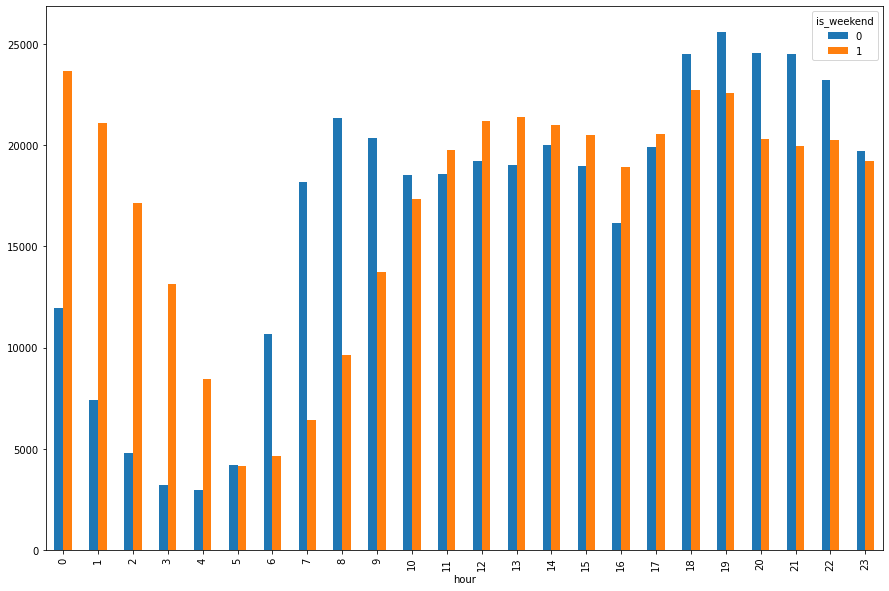

In [61]:
## demands between week days and weekends

merged_df.groupby(['hour', 'is_weekend'])['cnt'].mean().unstack().plot(kind='bar', figsize=(15,10))

In [62]:
 merged_df.groupby(['is_weekend', 'hour']).mean()['cnt'].unstack().T

is_weekend,0,1
hour,,
0,11974.724138,23671.461538
1,7410.674330,21079.548077
2,4772.371648,17161.298077
3,3224.118774,13137.884615
4,2948.406130,8450.528846
5,4224.076628,4136.951923
6,10660.869732,4626.615385
7,18168.164751,6424.211538
8,21322.333333,9630.750000


In [63]:
average_df = merged_df.groupby(['is_weekend', 'hour']).mean()['cnt'].unstack().T.rename(columns={0:"weekday", 1:"weekend"})

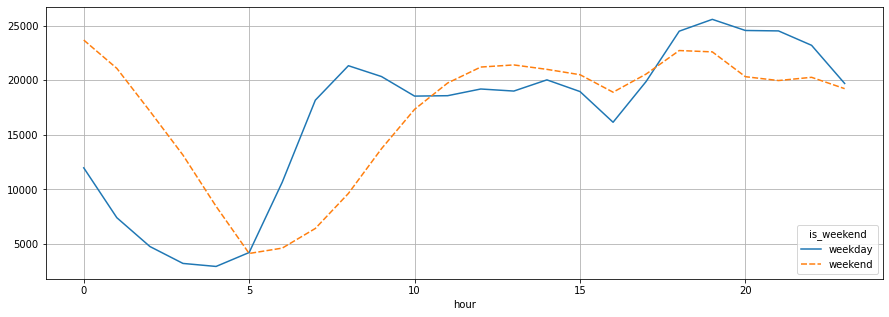

In [140]:
ax = plt.figure(figsize=(15,5))
ax = plt.grid()
ax = sns.lineplot(data=average_df)

### 2. With geometric data

In [13]:
def big_query_with_geometric(year, month):
    """
    A function: Query for GCP, extract the counts of taxi demands per hour and monthly and to_csv
    including geometric mapping
    """
       
    sql = """
WITH base_data AS (
  SELECT 
    *
  FROM bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_{0}
  WHERE EXTRACT(MONTH from pickup_datetime) = {1}
), temp AS (
  SELECT nyc_taxi.*, gis.* 
  FROM (
    SELECT *
    FROM base_data
    WHERE pickup_latitude  <= 90 and pickup_latitude >= -90
    ) as nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) as gis 
  ON st_contains(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
  zip_code, 
  city,
  DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
  count(*) as cnt
FROM temp
GROUP BY zip_code, city, pickup_hour
ORDER BY pickup_hour

"""
    
    bq = pd.read_gbq(query=sql.format(year, month), dialect='standard', 
                     project_id='direct-plateau-291323', auth_local_webserver=True)
    
    return bq.to_csv('nyc-yellow-taxi-geo-{}-{}.csv'.format(year, month))

In [14]:
## querying loop for year 2015 and 2016 data

year_list = [2015, 2016]
for i in year_list:
    for j in range(1,13):
        big_query_with_geometric(i, j)

In [21]:
## csv file merging preps

path = os.getcwd()

all_files = glob.glob(os.path.join(path, "nyc-yellow-taxi-geo-2015-*.csv"))

all_df = []

for f in all_files:
    df = pd.read_csv(f, sep=',')
    all_df.append(df)
    
merged_df = pd.concat(all_df, ignore_index=True, sort=True)
merged_df['pickup_hour'] = pd.to_datetime(merged_df['pickup_hour'])
merged_df = merged_df.sort_values(by='pickup_hour')

In [66]:
geo_df_2015 = pd.read_csv('nyc-yellow-taxi-geo-2015-total.csv')

In [68]:
geo_df_2015.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [69]:
geo_df_2015.head()

,city,cnt,pickup_hour,zip_code
0,New York city,835,2015-01-01 00:00:00,10028
1,New York city,99,2015-01-01 00:00:00,11222
2,New York city,3,2015-01-01 00:00:00,10279
3,New York city,23,2015-01-01 00:00:00,11109
4,New York city,762,2015-01-01 00:00:00,10012


In [71]:
zip_list = list(geo_df_2015.zip_code.values)

In [72]:
new_zip_list = []
for i in zip_list:
    new_zip_list.append('{}'.format(i))

In [73]:
len(zip_list)

1046730

In [74]:
nomi = pgeocode.Nominatim('us')
nomi_df = nomi.query_postal_code(new_zip_list)[['postal_code', 'latitude', 'longitude']]

In [79]:
nomi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046730 entries, 0 to 1046729
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   postal_code  1046730 non-null  object 
 1   latitude     1046730 non-null  float64
 2   longitude    1046730 non-null  float64
dtypes: float64(2), object(1)
memory usage: 71.9+ MB


In [75]:
geo_df_2015_merged = geo_df_2015.join(nomi_df, how='left')

In [77]:
geo_df_2015_merged

,city,cnt,pickup_hour,zip_code,postal_code,latitude,longitude
0,New York city,835,2015-01-01 00:00:00,10028,10028,40.7763,-73.9529
1,New York city,99,2015-01-01 00:00:00,11222,11222,40.7272,-73.9498
2,New York city,3,2015-01-01 00:00:00,10279,10279,40.7127,-74.0078
3,New York city,23,2015-01-01 00:00:00,11109,11109,40.7454,-73.9575
4,New York city,762,2015-01-01 00:00:00,10012,10012,40.7255,-73.9983
...,...,...,...,...,...,...,...
1046725,New York city,7,2015-12-31 23:00:00,10111,10111,40.7592,-73.9778
1046726,New York city,8,2015-12-31 23:00:00,10455,10455,40.8153,-73.9072
1046727,New York city,543,2015-12-31 23:00:00,10036,10036,40.7597,-73.9918
1046728,New York city,5,2015-12-31 23:00:00,11374,11374,40.7278,-73.8602


In [80]:
per_zip_code = geo_df_2015_merged.groupby(['zip_code', 'latitude', 'longitude'])[['cnt']].sum().reset_index()

In [81]:
per_zip_code

,zip_code,latitude,longitude,cnt
0,10001,40.7484,-73.9967,7234694
1,10002,40.7152,-73.9877,2661537
2,10003,40.7313,-73.9892,7769264
3,10004,40.7143,-74.0060,802913
4,10005,40.7056,-74.0083,644155
...,...,...,...,...
626,14858,42.0284,-77.1397,1
627,14859,42.1149,-76.5366,1
628,14870,42.1710,-77.1194,1
629,14877,42.0726,-77.6767,1


In [82]:
import folium

In [83]:
def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=12):
    '''
    Create a base map
    '''
    base_map = folium.Map(
        location = default_location
        , control_scale = True
        , zoom_start = default_zoom_start
    )
    
    return base_map

In [84]:
m = generateBaseMap()

for i in range(0, len(per_zip_code)):
    folium.Marker(location=[per_zip_code.iloc[i]['latitude'], per_zip_code.iloc[i]['longitude']], popup=per_zip_code.iloc[i]['cnt']).add_to(m)
m

In [85]:
from folium.plugins import HeatMap

m = generateBaseMap()

heat_map_data = per_zip_code[['latitude', 'longitude', 'cnt']].values.tolist()

HeatMap(heat_map_data, blur=10, max_zoom=10, radius = 10).add_to(m)

m